In [349]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from category_encoders import *

import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import re
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

# EDA

In [350]:
""" 
Считываем данные и оформляем в DataFrame
"""
df_train = pd.read_csv('archive/train.csv').drop(['ID', 'Levy', 'Model'], axis=1)
df_train = df_train.sample(frac=0.3)
df_test = pd.read_csv('archive/test.csv').drop(['ID', 'Levy', 'Model'], axis=1)
df_test = df_test.sample(frac=0.3)

df_train

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
18716,11290,TOYOTA,2012,Sedan,No,Hybrid,1.5,100000 km,4.0,Tiptronic,Front,04-May,Left wheel,Black,12
18606,27654,SSANGYONG,2014,Jeep,Yes,Diesel,2,105821 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
13573,10036,FORD,2015,Sedan,Yes,Hybrid,2,100747 km,4.0,Automatic,Front,04-May,Left wheel,Green,12
8390,21012,TOYOTA,2013,Sedan,No,Hybrid,1.8,145600 km,4.0,Automatic,Front,04-May,Left wheel,Black,0
11898,7527,MERCEDES-BENZ,1999,Goods wagon,No,Diesel,2.2 Turbo,150000 km,4.0,Manual,Rear,04-May,Left wheel,Silver,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,21953,HYUNDAI,2009,Minivan,Yes,Diesel,2.5 Turbo,150000 km,6.0,Automatic,Rear,>5,Left wheel,Silver,0
9296,3450,TOYOTA,2019,Sedan,Yes,Hybrid,2.5,9626 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
13530,4077,HYUNDAI,2012,Sedan,Yes,Hybrid,2.4,259934 km,4.0,Automatic,Front,04-May,Left wheel,Red,0
16625,157,LEXUS,2012,Jeep,Yes,Petrol,4.6,189704 km,8.0,Automatic,4x4,04-May,Left wheel,Grey,0


Text(0.5, 0, 'Марка')

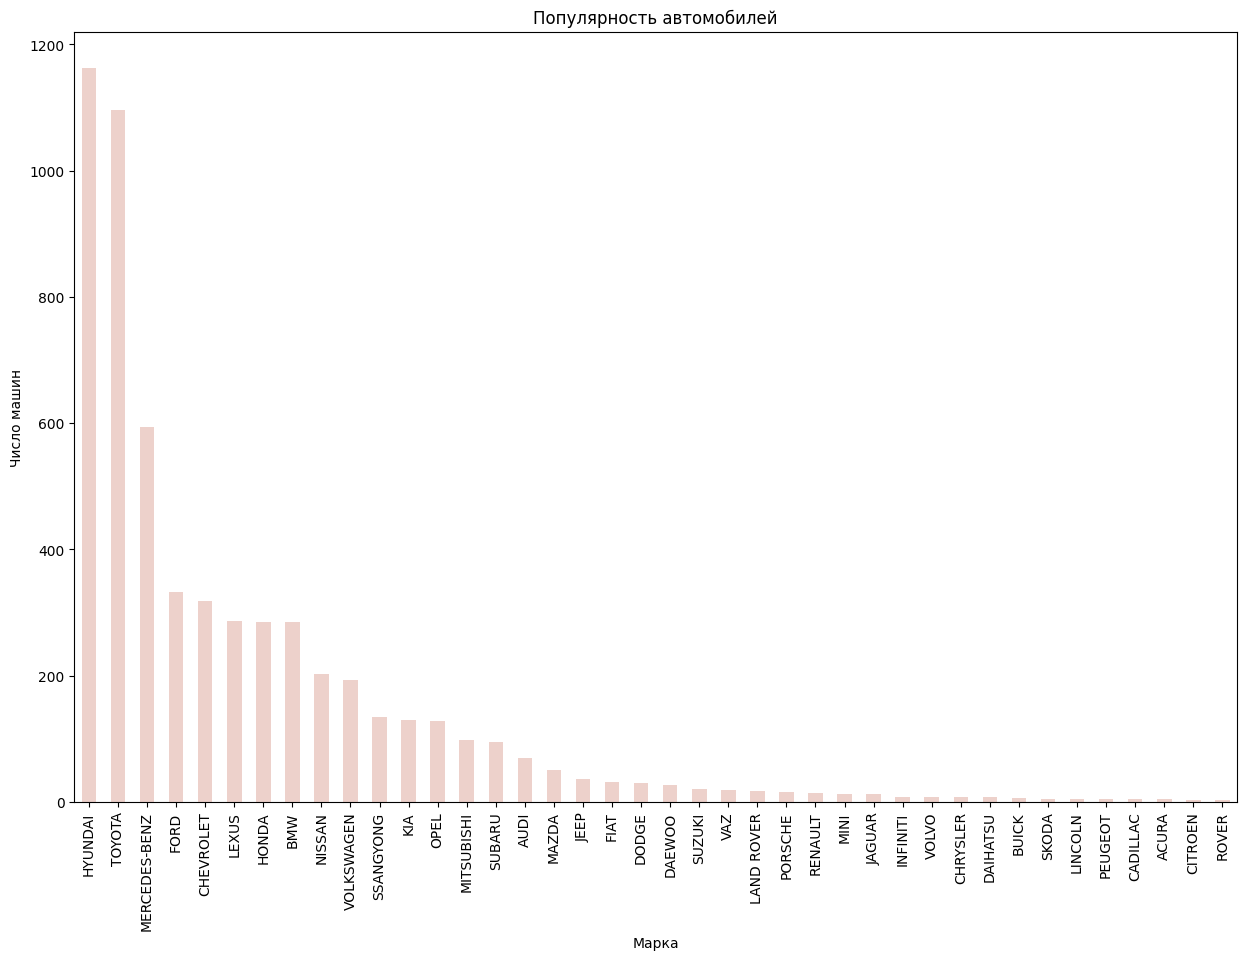

In [351]:
df_train.Manufacturer.value_counts().nlargest(40).plot(kind='bar', figsize=(15,10), colormap=sns.cubehelix_palette(as_cmap=True))
plt.title("Популярность автомобилей")
plt.ylabel('Число машин')
plt.xlabel('Марка')

In [352]:
""" 
Избавляемся от пробелов в датасете
"""

for column in df_train.columns:
    most_frequent_category = df_train[column].mode()[0]
    df_train[column] = df_train[column].replace(['NaN','?', ''], most_frequent_category)
    df_test[column] = df_test[column].replace(['NaN', '?', ''], most_frequent_category)
df_train

,Price,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
18716,11290,TOYOTA,2012,Sedan,No,Hybrid,1.5,100000 km,4.0,Tiptronic,Front,04-May,Left wheel,Black,12
18606,27654,SSANGYONG,2014,Jeep,Yes,Diesel,2,105821 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
13573,10036,FORD,2015,Sedan,Yes,Hybrid,2,100747 km,4.0,Automatic,Front,04-May,Left wheel,Green,12
8390,21012,TOYOTA,2013,Sedan,No,Hybrid,1.8,145600 km,4.0,Automatic,Front,04-May,Left wheel,Black,0
11898,7527,MERCEDES-BENZ,1999,Goods wagon,No,Diesel,2.2 Turbo,150000 km,4.0,Manual,Rear,04-May,Left wheel,Silver,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,21953,HYUNDAI,2009,Minivan,Yes,Diesel,2.5 Turbo,150000 km,6.0,Automatic,Rear,>5,Left wheel,Silver,0
9296,3450,TOYOTA,2019,Sedan,Yes,Hybrid,2.5,9626 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
13530,4077,HYUNDAI,2012,Sedan,Yes,Hybrid,2.4,259934 km,4.0,Automatic,Front,04-May,Left wheel,Red,0
16625,157,LEXUS,2012,Jeep,Yes,Petrol,4.6,189704 km,8.0,Automatic,4x4,04-May,Left wheel,Grey,0


In [353]:
""" 
Обрабатываем значения в столбце, которые численные, но с лишними подписями
"""
df_train['Engine volume'] = df_train['Engine volume'].apply(lambda x:float(re.sub('[^0-9]+', '', x)))
df_train['Mileage'] = df_train['Mileage'].apply(lambda x:int(re.sub('[^0-9]+', '', x)))
df_test['Engine volume'] = df_test['Engine volume'].apply(lambda x:float(re.sub('[^0-9]+', '', x)))
df_test['Mileage'] = df_test['Mileage'].apply(lambda x:int(re.sub('[^0-9]+', '', x)))


In [354]:
""" 
Изучаем датасет на выбросы
"""
df_train.describe()

,Price,Prod. year,Engine volume,Mileage,Cylinders,Airbags
count,5771.000000,5771.000000,5771.000000,5.771000e+03,5771.000000,5771.000000
mean,17039.951828,2010.916132,17.782187,9.413878e+05,4.557269,6.564547
std,21262.589110,5.737278,12.184936,3.456735e+07,1.178948,4.305345
min,1.000000,1939.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,5096.500000,2009.000000,3.000000,6.888050e+04,4.000000,4.000000
50%,12858.000000,2012.000000,18.000000,1.256210e+05,4.000000,6.000000
75%,21767.500000,2015.000000,25.000000,1.900000e+05,4.000000,12.000000
max,872946.000000,2020.000000,68.000000,2.147484e+09,16.000000,16.000000


In [355]:
""" 
Выясняем численные признаки
"""

numbers_features = []
for column in df_train.columns:
    if df_train[column].dtype !='object':
        numbers_features.append(column)
numbers_features

['Price', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']

In [356]:
""" 
Удаляем выбросы с помощью квантиль .05-.95
"""
for feature in numbers_features:

    Q1 = df_train[feature].quantile(q = .05)
    Q3 = df_train[feature].quantile(q = .95)
    IQR = Q3 - Q1
    df_train = df_train[(df_train[feature] >= Q1 - 1.5 * IQR) & (df_train[feature] <= Q3 + 1.5 * IQR)] 

df_train = df_train.reset_index(drop = True)
df_train.shape

(5717, 15)

In [357]:
""" 
Создаем датасет только без категориальных признаков
"""
df_numbers_train = df_train[numbers_features]
df_numbers_test = df_test[numbers_features]

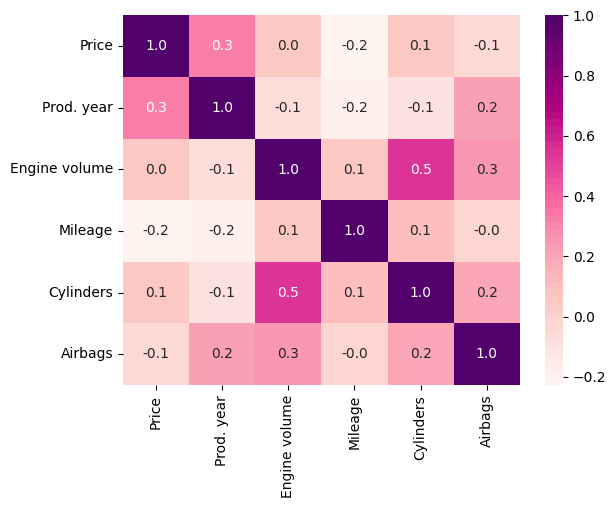

In [358]:
""" 
Визуализируем корреляцию между признаками
"""
sns.heatmap(df_numbers_train.corr(), annot = True, fmt=".1f", cmap= sns.color_palette("RdPu", 50))
plt.show()

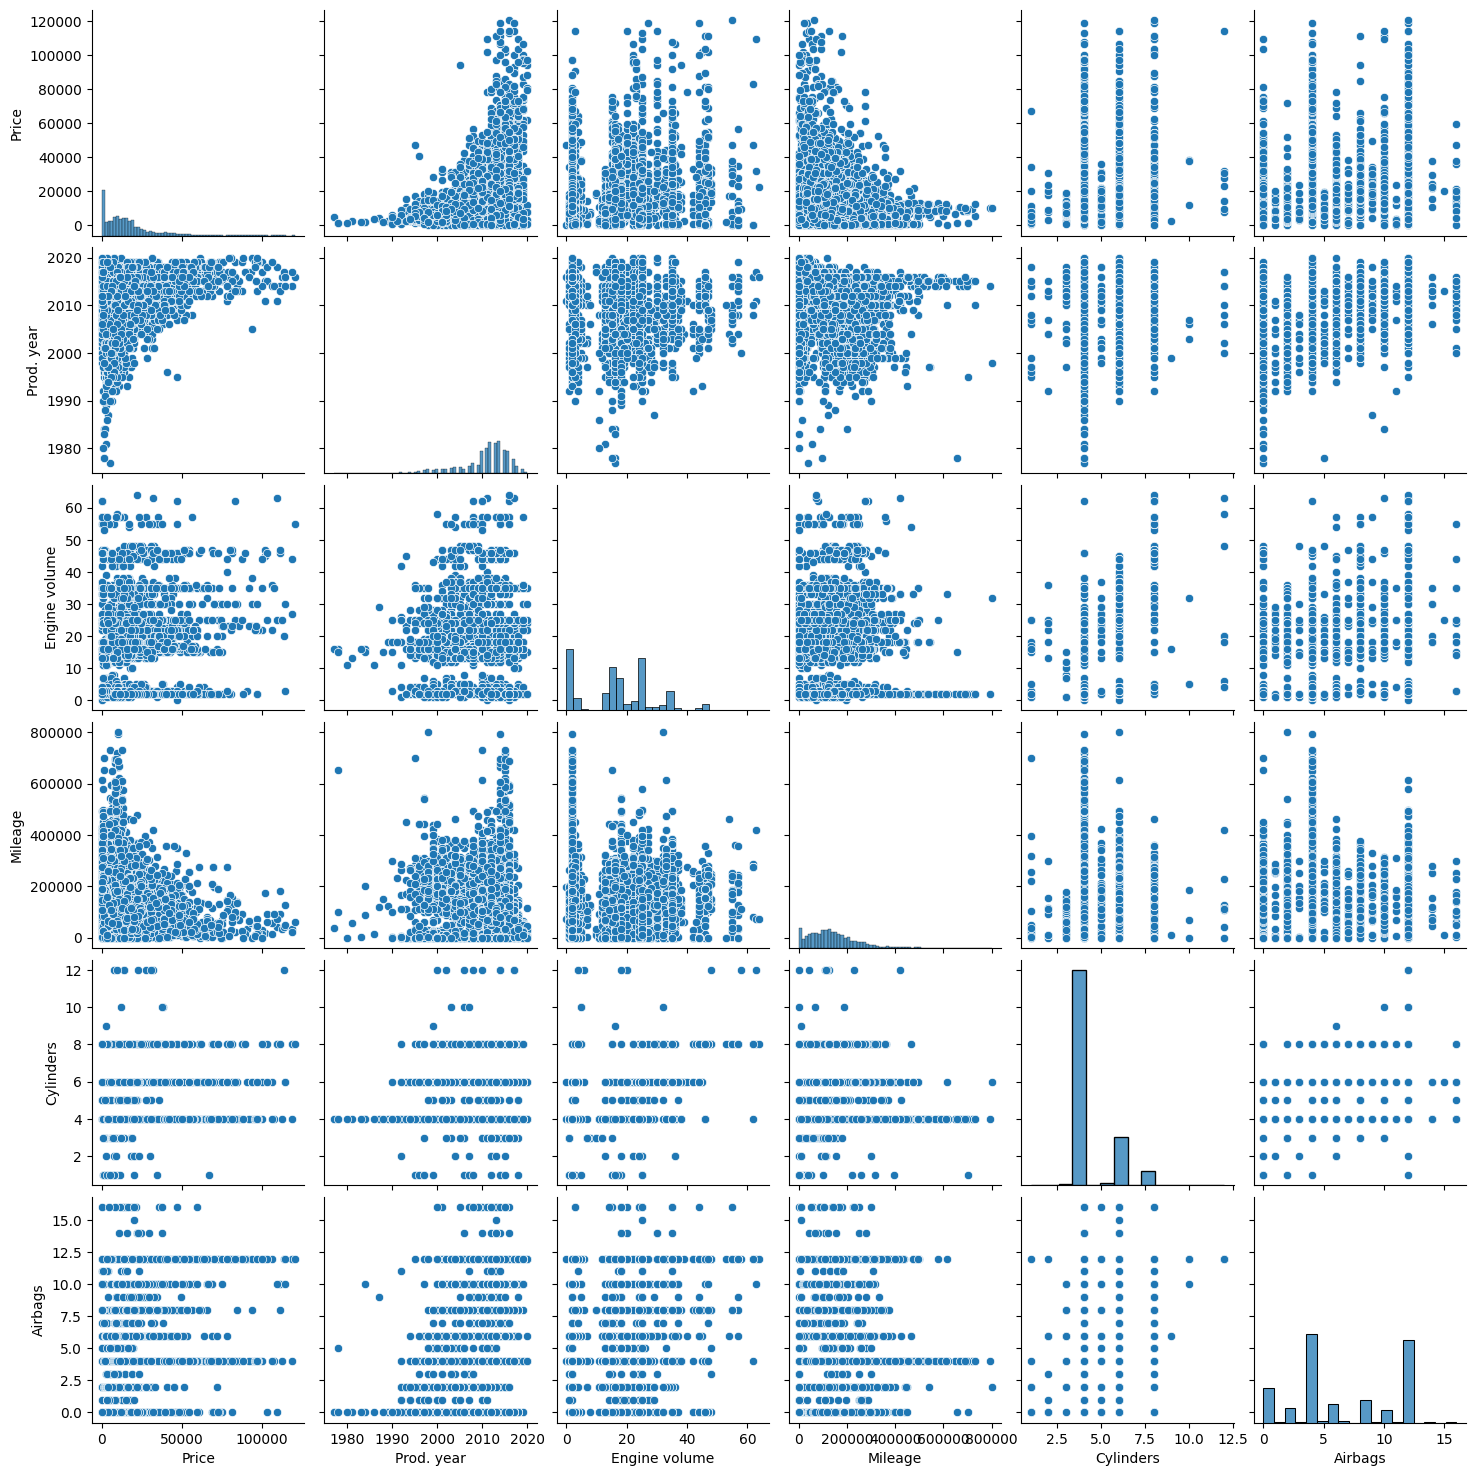

In [359]:
sns.pairplot(df_numbers_train)


# Задание №1, №2

### Построить линейную регрессию. Построить решение методом бустинга. Сравнить с линейной регрессией.

In [360]:
from sklearn import linear_model 
reg = linear_model.LinearRegression()

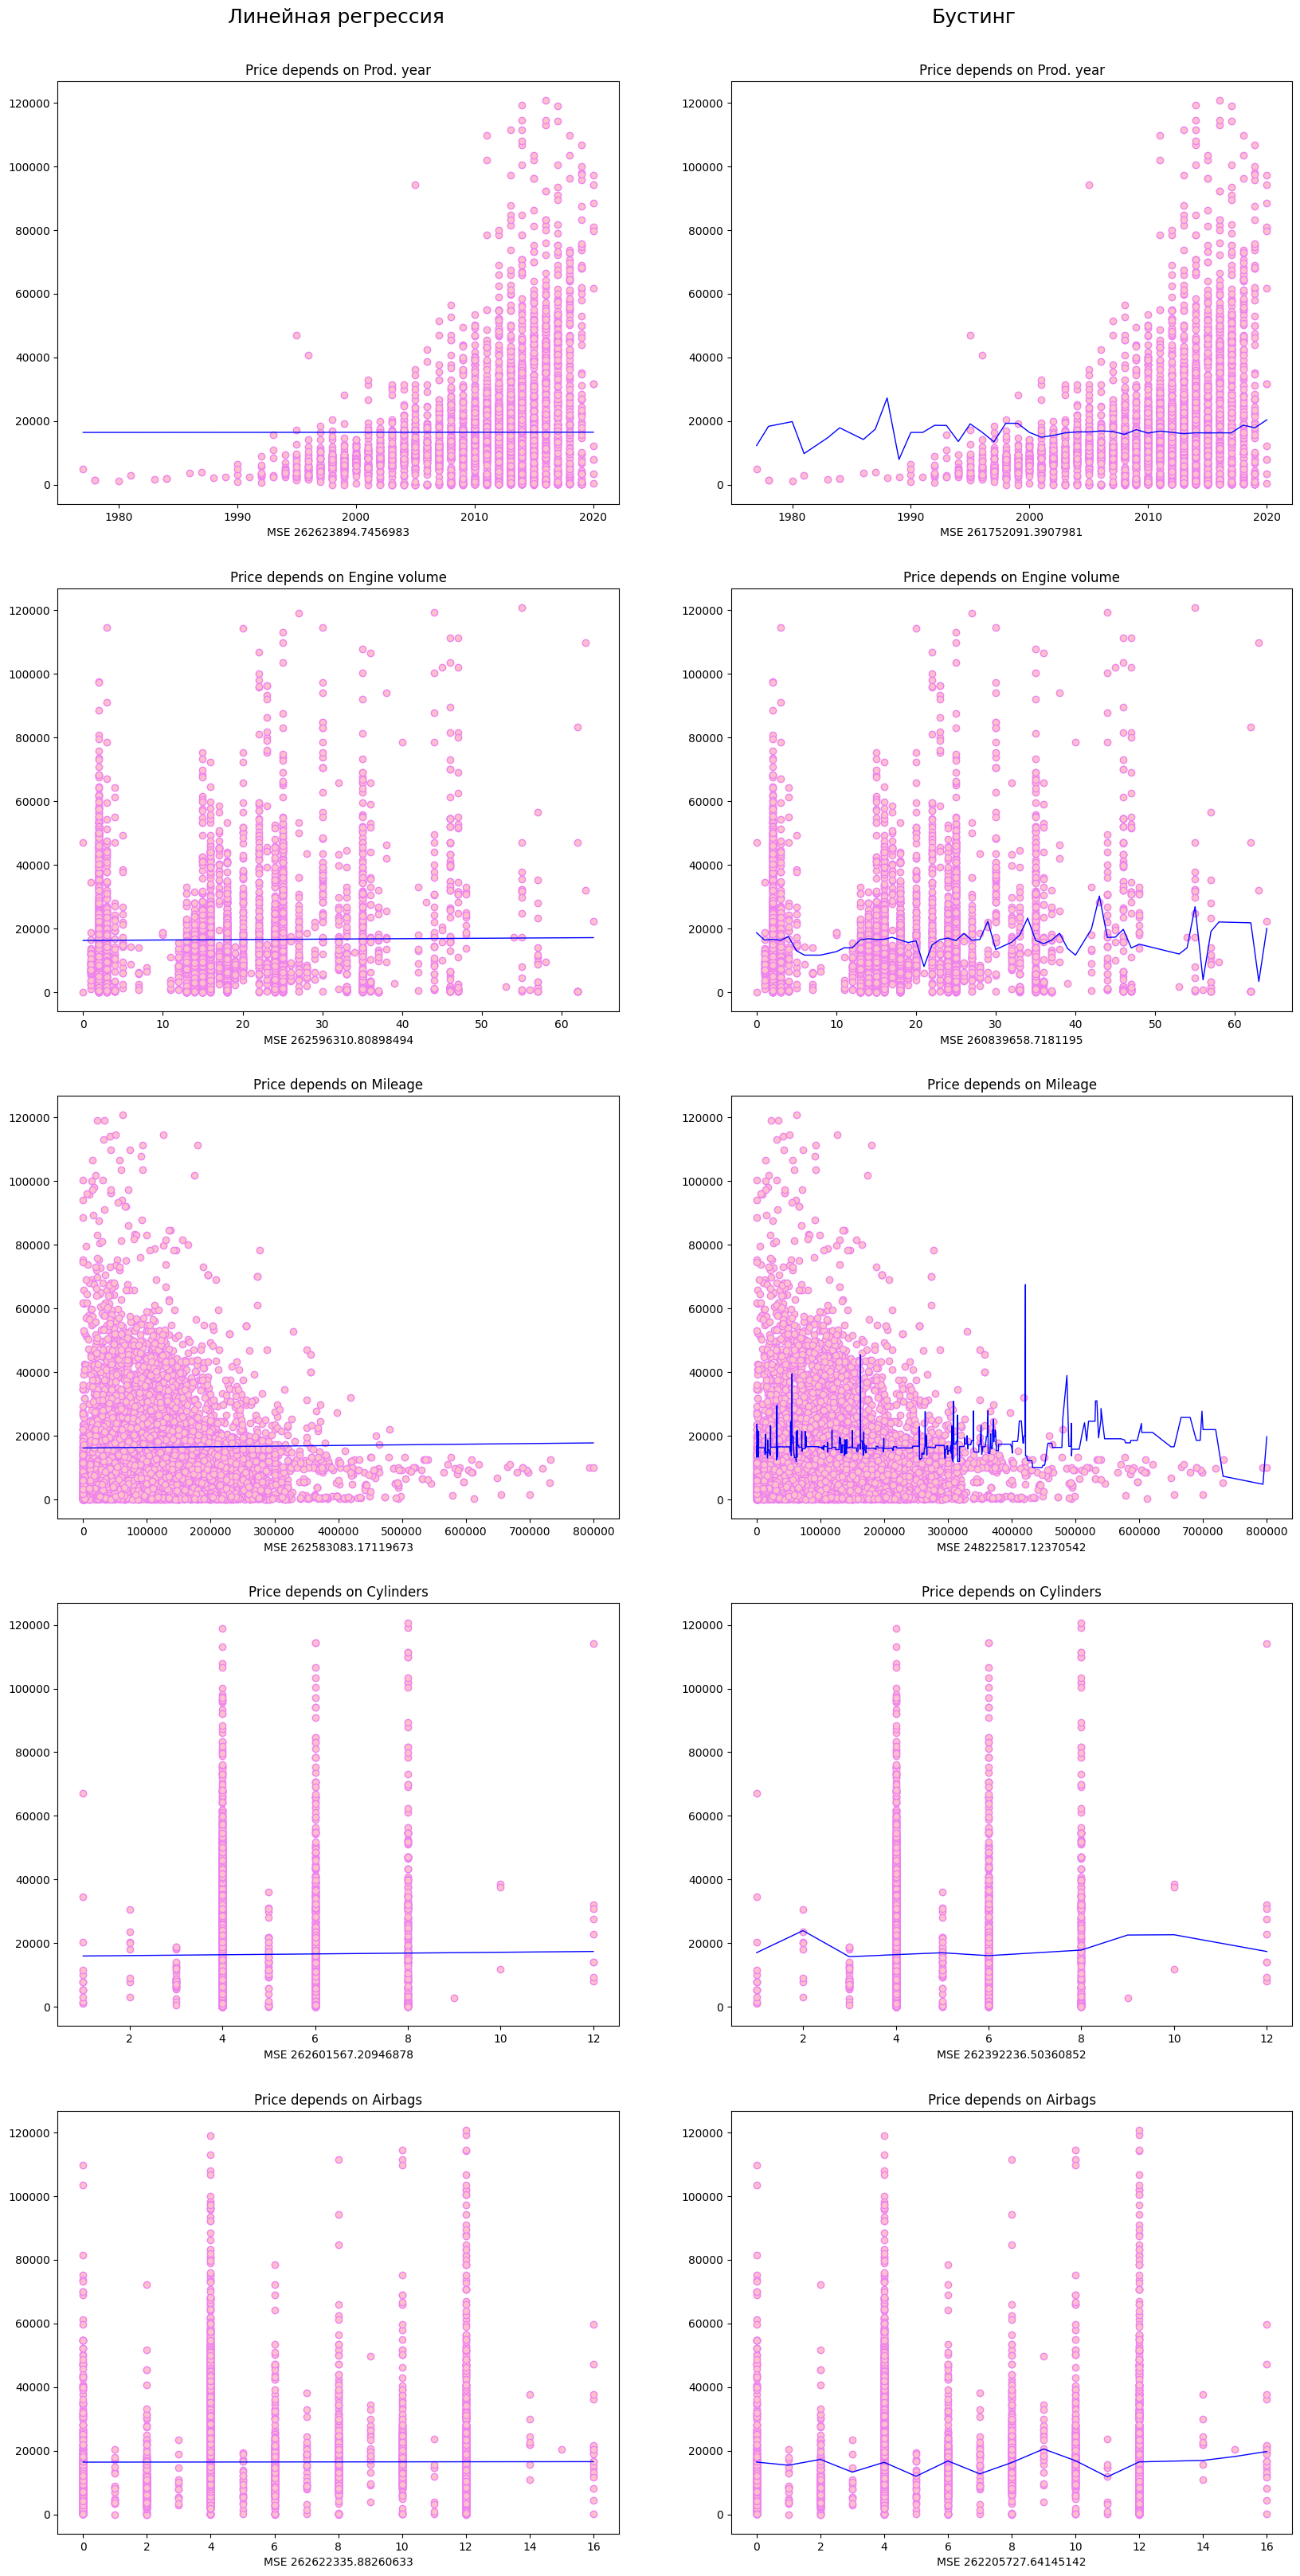

In [361]:
""" 
Сравниваем работу линейной регрессии с градиентным бустингом
"""
fig, axs = plt.subplots(nrows= len(numbers_features[1:]) , ncols= 2, figsize=(20, 40))
fig.text(s='Линейная регрессия', x=0.3, y=0.9, fontsize=18, ha='center', va='center')
fig.text(s='Бустинг', x=0.7, y=0.9, fontsize=18, ha='center', va='center')

for i, c in enumerate(df_numbers_test.columns[1:]):

    reg = linear_model.LinearRegression()

    x = df_numbers_train.sort_values(by=c)
    X = x[c].values.reshape(-1,1)
    reg.fit(X, df_numbers_train['Price'])
    y_pred = reg.predict(X)

    m = metrics.mean_squared_error(df_numbers_train['Price'], y_pred)

    axs[i, 0].plot(X, y_pred, color="blue", linewidth=1)
    axs[i, 0].scatter(df_numbers_train[c], df_numbers_train['Price'], color="pink", edgecolors = 'violet')
    axs[i, 0].set_title("Price depends on " + c)
    axs[i, 0].set(xlabel = 'MSE ' + str (m))


    gb_model = GradientBoostingRegressor()

    gb_model.fit(X, df_numbers_train['Price'])
    y_pred = gb_model.predict(X)
    
    m = metrics.mean_squared_error(df_numbers_train['Price'], y_pred)

    axs[i, 1].plot(X, y_pred, color="blue", linewidth=1)
    axs[i, 1].scatter(df_numbers_train[c], df_numbers_train['Price'], color="pink", edgecolors = 'violet')
    axs[i, 1].set_title("Price depends on " + c)
    axs[i, 1].set(xlabel = 'MSE ' + str (m))


# Задание №3

### Применить one hot и target encoding для категориальных признаков (взять данные, где такие признаки есть). Сравнить точность.


In [362]:
df_label = df_train
categorial_features = []

In [363]:
""" 
Применяем target encoding ко всем категориальным признакам
"""

df_category = df_train.select_dtypes([object])
X = TargetEncoder().fit_transform(df_category, df_train['Price'])

In [364]:
reg = linear_model.LinearRegression()
reg.fit(X, df_train['Price'])
reg_y_pred = reg.predict(X)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_model.fit(X, df_train['Price'])
gb_y_pred = gb_model.predict(X)

In [365]:
print('Test MSE LR ', metrics.mean_squared_error(reg_y_pred, y_pred))
print('Test MSE GB ',  metrics.mean_squared_error(gb_y_pred, y_pred))

Test MSE LR  54668836.57738666
Test MSE GB  71687558.946444


In [366]:
""" 
Применяем one hot encoding к всем категориальным признакам
"""
X = pd.get_dummies(df_category)
X

,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,Manufacturer_AUDI,Manufacturer_BMW,Manufacturer_BUICK,Manufacturer_CADILLAC,Manufacturer_CHEVROLET,Manufacturer_CHRYSLER,Manufacturer_CITROEN,Manufacturer_DAEWOO,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
5713,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5714,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5715,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [367]:
reg = linear_model.LinearRegression()
reg.fit(X, df_train['Price'])
reg_y_pred = reg.predict(X)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
gb_model.fit(X, df_train['Price'])
gb_y_pred = gb_model.predict(X)

In [368]:
print('Test MSE LR ', metrics.mean_squared_error(reg_y_pred, y_pred))
print('Test MSE GB ',  metrics.mean_squared_error(gb_y_pred, y_pred))

Test MSE LR  65705912.89409767
Test MSE GB  59078590.55109017


# Задание №4

### Визуализировать объекты (не обязательно для той же таблицы) в пространстве главных компонент.


In [369]:
x_train  = df_numbers_train.drop(['Price'], axis = 1)
scaler = StandardScaler()
scaled_df = x_train.copy()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns = scaled_df.columns)

In [370]:
pca = PCA()
pca_fit = pca.fit(scaled_df)

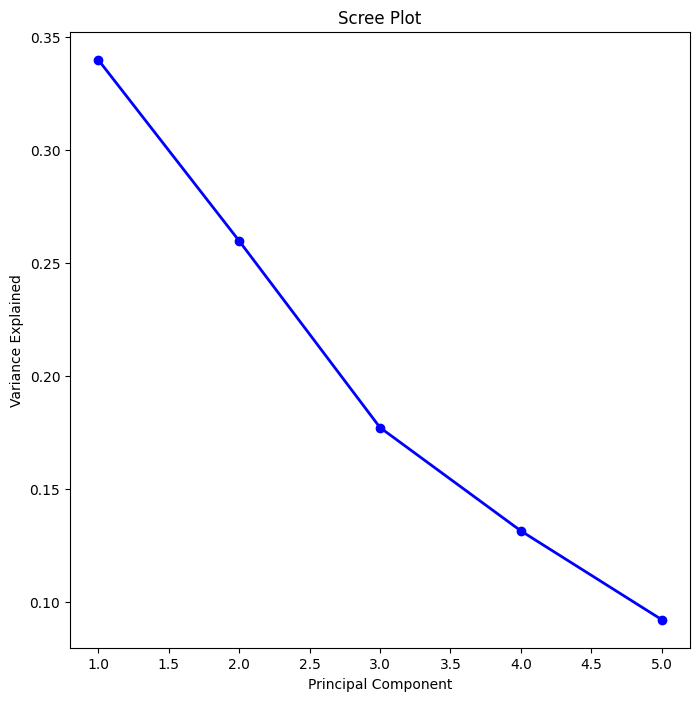

In [371]:
PC_values = np.arange(pca.n_components_) + 1
plt.figure(figsize=(8,8))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [372]:
print("Объем данных для каждой компоненты :", pca.explained_variance_ratio_)
print("Объем данных для каждого числа компонент :", np.cumsum(pca.explained_variance_ratio_))

Объем данных для каждой компоненты : [0.33998673 0.25975591 0.17705854 0.13126525 0.09193358]
Объем данных для каждого числа компонент : [0.33998673 0.59974263 0.77680117 0.90806642 1.        ]


In [373]:
import plotly.express as px
pca = PCA()
components = pca.fit_transform(scaled_df)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df_train["Price"],
)
fig.update_traces(diagonal_visible=False)
fig.update_layout(width=1400,height=800,hovermode='closest',)
fig.show()

In [374]:
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df_train['Price'])
fig.show()

fig = px.scatter(components, x=0, y=1)
for i, feature in enumerate(x_train.columns):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=10,
        font=dict(
            family="sans serif",
            size=20,
            color="black"
            )
    )
fig.show()